# Phishing URL Detection

The purpose of this project is to detect malicious phishing URL. The model implemented is a hybrid LSTM and CNN model. 

## Data Cleaning

In [2]:
import pandas as pd

In [3]:
#load dataset 
data = pd.read_csv("data/phishing_site_urls.csv")
data

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
...,...,...
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad


In [4]:
#make sure there's no NaN values
data = data.dropna()

#dropping duplicates
data.drop_duplicates(inplace=True)
data = data.reset_index(drop=True)
data

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
...,...,...
507191,23.227.196.215/,bad
507192,apple-checker.org/,bad
507193,apple-iclods.org/,bad
507194,apple-uptoday.org/,bad


good    392897
bad     114299
Name: Label, dtype: int64

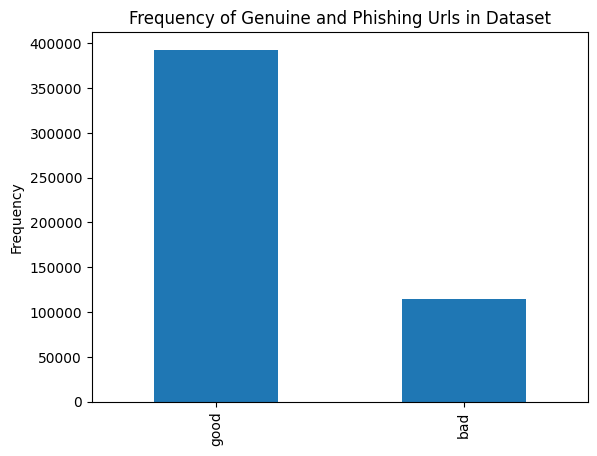

In [5]:
graph = data['Label'].value_counts().plot(kind='bar', title = 'Frequency of Genuine and Phishing Urls in Dataset')
graph.set_ylabel("Frequency")
data['Label'].value_counts()

In [6]:
# encode label
data['Label'] = data['Label'].replace(['bad', 'good'], [1, 0])
data

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1
3,mail.printakid.com/www.online.americanexpress....,1
4,thewhiskeydregs.com/wp-content/themes/widescre...,1
...,...,...
507191,23.227.196.215/,1
507192,apple-checker.org/,1
507193,apple-iclods.org/,1
507194,apple-uptoday.org/,1


0    114299
1    114299
Name: Label, dtype: int64

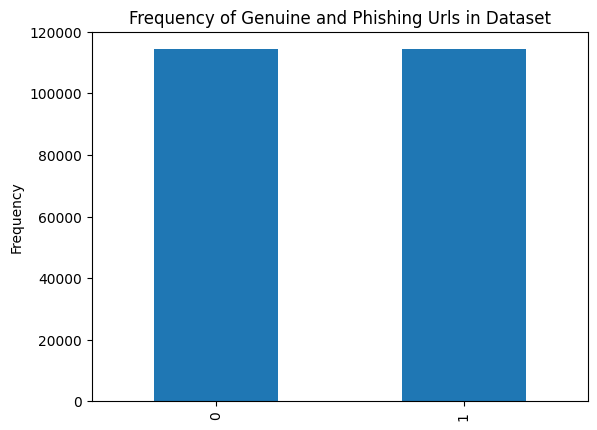

In [7]:
import random 
#DID NOT USE THIS IN FINAL IMPLEMENTATION
#can remove data unbalance by undersampling data with non-phishing label

#retrieve number of phishing samples
phishNum = len(data[data['Label'] == 1])

#find indices of phishing and non-phishing samples 
phishing = data[data['Label'] == 1].index
nophishing = data[data['Label'] == 0].index

#pick a sample (same size as phishing) of non-phishing data
new_nophishingindx = random.sample(list(nophishing), k = len(phishing))

#concatenate the two lists of index
undersampleindx = new_nophishingindx + list(phishing)

#get undersampled dataframe from the merged indices
undersampled = data.loc[undersampleindx]

#graph frequency of labels
graph = undersampled['Label'].value_counts().plot(kind='bar', title = 'Frequency of Genuine and Phishing Urls in Dataset')
graph.set_ylabel("Frequency")
undersampled['Label'].value_counts()


## Pre-Processing

In [8]:
from string import printable
import tensorflow as tf
import numpy as np
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split


In [9]:

#use hashing methods 
#convert each url to a vector by mapping each character to a numerical value 
url_tokens = []
for url in data.URL:
    vector_url = []

    for x in url:
        if x in printable:
            vector_url.append(printable.index(x) + 1)
    url_tokens.append(vector_url)

#ensure that all vectors are the same size by adding padding 
x = pad_sequences(url_tokens, maxlen = 75, padding = 'post')
y = data.Label

print('Matrix dimensions of X: ', x.shape, 'Vector dimension of response: ', y.shape)


#this can also be done by finding the unicode of each character in string using ord()
# url_tok = []
# for url in data.URL:
#     vector = []
#     for x in url:
#         vector.append(ord(x))
#     url_tok.append(vector)

# x = pad_sequences(url_tok, maxlen = 75, padding = 'post')
# y = np.array(data['Label'].copy()).astype(int)

# print(y)
# print(x)



Matrix dimensions of X:  (507196, 75) Vector dimension of response:  (507196,)


In [10]:
#split our dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((405756, 75), (101440, 75), (405756,), (101440,))

## Classification

In [11]:
from keras.datasets import imdb
from keras.layers import Embedding, Dense, LSTM, Conv1D, BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.losses import BinaryCrossentropy

from keras.models import Sequential
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [12]:

# was advised to train model for more than 2 epochs
# Model configuration
additional_metrics = ['accuracy']
batch_size = 512
embedding_output_dims = 32
loss_function = BinaryCrossentropy()
max_sequence_length = 75
num_distinct_char = 101
number_of_epochs = 2
optimizer = Adam()
validation_split = 0.20
verbosity_mode = 1

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Define the Keras model
model = Sequential()

model.add(Embedding(num_distinct_char, embedding_output_dims, input_length = max_sequence_length))
model.add(Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(LSTM(10, return_sequences = False))
model.add(Dense(1, activation = 'sigmoid'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)

# Give a summary
model.summary()

# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=number_of_epochs, verbose=verbosity_mode, validation_split=validation_split)

# Test the model after training
test_results = model.evaluate(x_test, y_test, verbose = False)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 75, 32)            3232      
                                                                 
 conv1d (Conv1D)             (None, 73, 128)           12416     
                                                                 
 batch_normalization (BatchN  (None, 73, 128)          512       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 10)                5560      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 21,731
Trainable params: 21,475
Non-

## Evaluation

In [13]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay

y_pred = model.predict(x_test)
y_pred = np.where(y_pred >= 0.5, 1, 0)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     78574
           1       0.92      0.91      0.91     22866

    accuracy                           0.96    101440
   macro avg       0.95      0.94      0.94    101440
weighted avg       0.96      0.96      0.96    101440

[[76728  1846]
 [ 2106 20760]]


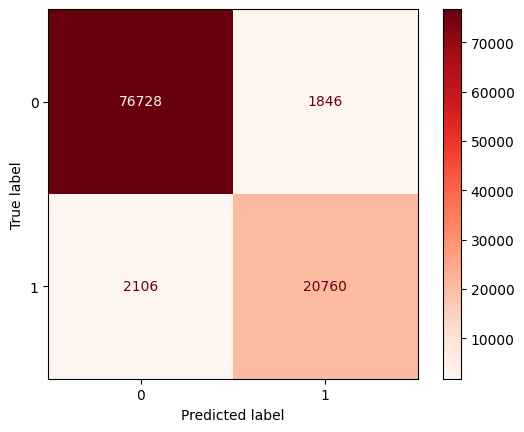

In [14]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(cmap = 'Reds', values_format='')

In [21]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("  Confusion Matrix")

print("     TP     FP")
print("     FN     TN\n")

matrix = np.array([[tn, fp], [fn, tp]])
print(matrix)
print()

#ACCURACY
accuracy = (tp+tn)/(tp+fp+tn+fn)
print("   Accuracy: %.5f" % accuracy)
#PRECISION
precision = tp/(tp+fp)
print("   Precision: %.5f" % precision)
#RECALL 
recall = tp/(tp+fn)
print("   Recall: %.5f" % recall)
#F1
f1 = (2*precision*recall)/(precision+recall)
print("   F1 score: %.5f" % f1)

  Confusion Matrix
     TP     FP
     FN     TN

[[76728  1846]
 [ 2106 20760]]

   Accuracy: 0.96104
   Precision: 0.91834
   Recall: 0.90790
   F1 score: 0.91309
